### Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
import math
import os

In [2]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

df = pd.read_csv(r"CSE575-HW03-Data.csv", header=None)
x = np.array(df)

## K-Means Clustering

In [3]:
class KMeansClustering:
    def __init__(self, no_of_clusters=5) -> None:
        self.no_of_clusters = no_of_clusters
        self.centroids = None

    def fit_transform(self, X, no_of_iterations=20):
        size = X.shape[0]
        x_max = X.max(dim=0)[0].unsqueeze(1)
        x_min = X.min(dim=0)[0].unsqueeze(1)

        dists = torch.zeros((size, self.no_of_clusters))
        best_loss = 1e5
        pred = None

        for _ in range(no_of_iterations):
            centroids = (x_min - x_max) * torch.rand((X.shape[1], self.no_of_clusters)) + x_max
            old_loss = -1
            while 1:
                for i in range(self.no_of_clusters):
                    ctr = centroids[:, i].unsqueeze(1)
                    dists[:, i] = (X - ctr.T).pow(2).sum(dim=1).sqrt()
                dists_min, labels = dists.min(dim=1)

                for i in range(self.no_of_clusters):
                    idx = torch.where(labels == i)[0]
                    if len(idx) == 0:
                        continue
                    
                    centroids[:, i] = X[idx].mean(dim=0)
                
                new_loss = dists_min.sum()
                if old_loss == new_loss:
                    break
                old_loss = new_loss

            if new_loss < best_loss:
                best_loss = new_loss
                pred = labels
            
            return pred

## Gaussian Mixture

In [7]:
class GaussianMixture():
	def __init__(self, no_of_components, no_of_iterations):
		self.no_of_components = no_of_components
		self.no_of_iterations = no_of_iterations

	def gaussian_likelihood(self, X, n):
		two_pi = torch.tensor(2 * math.pi, dtype=torch.float64)
		fact = 1 / torch.sqrt(torch.pow(two_pi, X.shape[0]) * torch.det(self.sigma[n]))

		X_minus_mu = X - self.mu[n].T
		sigma_inv = torch.inverse(self.sigma[n])
		return fact * torch.exp(-0.5 * X_minus_mu.mm(sigma_inv).mm(X_minus_mu.T))

	def e_step(self, X):
		for i in range(self.no_of_components):
			for j in range(self.no_of_samples):
				self.likelihoods[j, i] = self.gaussian_likelihood(X[j], i)

		prob_num = self.priors.T * self.likelihoods
		prob_den = prob_num.sum(dim=1).unsqueeze(1)
		self.probs = prob_num / prob_den

	def m_step(self, X):
		for j in range(self.no_of_components):
			probs_j = self.probs[:, j]
			probs_j_sum = probs_j.sum()
			self.priors[j] = probs_j.sum() / self.no_of_samples

			probs_j_uns = probs_j.unsqueeze(1)
			self.mu[j] = (probs_j_uns * X).sum(dim=0).unsqueeze(1)
			self.mu[j] /= probs_j_sum

			X_minus_mu = X - self.mu[j].T
			self.sigma[j].fill_(0.)
			for i in range(self.no_of_samples):
				row = X_minus_mu[i, :].unsqueeze(1)
				self.sigma[j] += probs_j[i] * row.mm(row.T)
			self.sigma[j] /= probs_j_sum

	def fit_predict(self, X):
		self.no_of_samples = X.shape[0]
		self.no_of_features = X.shape[1]

		self.sigma = torch.zeros((self.no_of_components, self.no_of_features, self.no_of_features), dtype=torch.float64)
		self.mu = torch.zeros((self.no_of_components, self.no_of_features, 1), dtype=torch.float64)
		self.priors = torch.zeros((self.no_of_components, 1), dtype=torch.float64).fill_(1 / self.no_of_components)

		kms = KMeansClustering(no_of_clusters=self.no_of_components)
		pred = kms.fit_transform(X).unsqueeze(1)
		self.probs = torch.zeros(self.no_of_samples, self.no_of_components)
		self.probs.scatter_(1, pred, 1)

		X_m = X - X.mean()
		X_cov = X_m.T.mm(X_m)
		for j in range(self.no_of_components):
			self.sigma[j] = X_cov.clone()
			self.mu[j] = X[torch.randint(0, self.no_of_samples, (1,))].T

		self.likelihoods = torch.zeros((self.no_of_samples, self.no_of_components), dtype=torch.float64)

		self.m_step(X)
		for _ in range(self.no_of_iterations):
			self.e_step(X)
			self.m_step(X)

		return self.probs.argmax(dim=1)

### Plot

<Axes: xlabel='0', ylabel='1'>

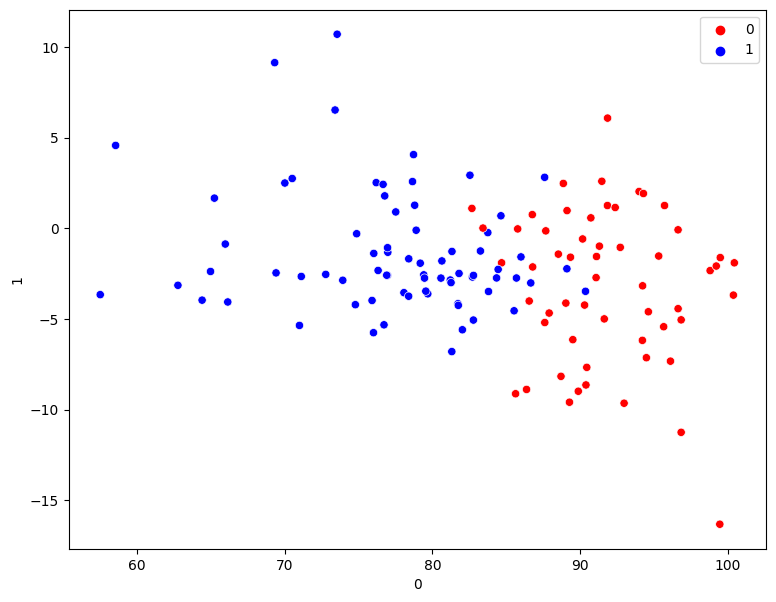

In [8]:
X = torch.from_numpy(x).float()
gmm = GaussianMixture(no_of_components=2, no_of_iterations=3)
pred_gmm = gmm.fit_predict(X)
plt.figure(figsize=(9, 7))
sns.scatterplot(data=df, x=0, y=1, hue=gmm.fit_predict(X), palette=["red", "blue"])